In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import cv2

In [117]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = model.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = (Z > 0.5).astype(int).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()


def plot_decision_boundary_one_hot(model, X, y, resolution=0.02):
    # Define the color maps
    markers = ('s', 'x', 'o', '^', 'v', '+', 'p', 'd', 'h', '8', '<', '>')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan', 'orange', 'pink', 'purple', 'brown', 'black', 'yellow', 'green')
    cmap = ListedColormap(colors[:len(np.unique(np.argmax(y, axis=1)))])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    grid = np.c_[xx.ravel(), yy.ravel()]
    
    Z = model.forward(grid)
    
    Z = np.argmax(Z, axis=1)
    
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot the data points
    for idx, cl in enumerate(np.unique(np.argmax(y, axis=1))):
        plt.scatter(x=X[np.argmax(y, axis=1) == cl, 0], 
                    y=X[np.argmax(y, axis=1) == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    plt.legend(loc='upper left')

    plt.show()


In [13]:
def df(f, a):
    h = 0.0001
    return ( f(a + h) - f(a) ) / h


def standard_scaler(x):
    """
     convert the data to have a mean of 0 and a standard deviation of 1
    """
    
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

<h1> MLP From Scratch</h1>

feed forward:

$$z^l_j = \sum_k w^l_{jk} a^{l-1}_k + b^l_j$$

$$a^l = \sigma(z^l)$$


backpropagation

$$\delta^L_j = \frac{\partial C}{\partial a^L_j} \sigma'(z^L_j)$$
$$\delta^L = \nabla_a C \odot \sigma'(z^L)$$

$$\delta^l = ((w^{l+1})^T \delta^{l+1}) \odot \sigma'(z^l)$$

$$\frac{\partial C}{\partial b^l_j} = \delta^l_j$$

$$\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j$$

$$
w^l \leftarrow w^l - \frac{\eta}{m} \sum_x \delta_{x,l} (a^{l-1}_x)^T
$$

$
\begin{aligned}
& w \text{ - weight, } 
& b \text{ - bias, } 
& z \text{ - preactivated neuron, } 
& a \text{ - activated neuron, } 
& l \text{ - layer, } 
& j \text{ - to neuron, } 
& k \text{ - from neuron, }
& x \text{ - sample, }
\end{aligned}
$


<h2> Backpropagation commented step by step </h2>

```python
# Output layer calculations
output_layer = self.layers[1]

# Calculate the delta for the output layer
output_delta = self.df_loss_mse(y_true, y_pred) * output_layer.df_activation(output_layer.output)
```
$$\delta^L = \nabla_a C \odot \sigma'(z^L)$$
```python
# Alternatively, if the loss is cross-entropy with sigmoid, output_delta = y_pred - y_true

hidden_layer = self.layers[0]

# Calculate the gradient for the output layer weights and biases
vw_loss_output = np.dot(hidden_layer.output.T, output_delta)
```
$$\frac{\partial C}{\partial w^2_{jk}} = a^{1}_k \delta^2_j$$
```python

# sum axis = 0 means sum for each sample
vb_loss_output = np.sum(output_delta, axis=0, keepdims=True)
```
$$\frac{\partial C}{\partial b^2_j} = \delta^2_j$$

```python

# Update weights and biases for the output layer
output_layer.weights = output_layer.weights - lp * vw_loss_output / batch_size
```

$$
w^2 \leftarrow w^2 - \frac{\eta}{m} \sum_x \delta_{x,2} (a^{1}_x)^T
$$

```python
output_layer.biases = output_layer.biases - lp * vb_loss_output / batch_size
```
$$
b^2 \leftarrow b^2 - \frac{\eta}{m} \sum_x \delta_{x,2}
$$

```python
# Next, process the previous hidden layer
# Transpose of output layer weights
activated_weights_from_output_to_hidden = output_layer.weights.T

# Calculate hidden layer error
# δL * wL.T
propageted_error = np.dot(output_delta, activated_weights_from_output_to_hidden)
```
$$ (w^{l+1})^T \delta^{l+1}$$

```python

# Calculate delta for hidden layer
hidden_derivative_activated = hidden_layer.df_activation(hidden_layer.output)
hidden_delta = propageted_error* hidden_derivative_activated
```
$$\delta^1 = ((w^{2})^T \delta^{2}) \odot \sigma'(z^1)$$

```python


# Calculate the gradient for hidden layer weights and biases
vw_loss_hidden = np.dot(inputs.T, hidden_delta)
vb_loss_hidden = np.sum(hidden_delta, axis=0, keepdims=True)

# Update weights and biases for the hidden layer where a0 is inputs
hidden_layer.weights = hidden_layer.weights - lp * vw_loss_hidden / batch_size
```

$$
w^0 \leftarrow w^1 - \frac{\eta}{m} \sum_x \delta_{x,1} (a^{0}_x)^T
$$

```python
hidden_layer.biases = hidden_layer.biases - lp * vb_loss_hidden / batch_size
```
$$
b^1 \leftarrow b^1 - \frac{\eta}{m} \sum_x \delta_{x,1}
$$

```python

In [369]:
np.random.seed(0)

class LayerDense:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def sigmoid(x):
        x = np.clip(x, -500, 500)
                
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def heaviside(x):
        return np.heaviside(x, 0)
    
    @staticmethod
    def softmax(x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return probs
    
    
    def df_activation(self, activated_output):
        """
            activated_output -> aL = σ(zL)
        """

        if self.activation == LayerDense.sigmoid:
            return activated_output * (1 - activated_output)
        elif self.activation == LayerDense.relu:
            return np.where(activated_output <= 0, 0, 1)
        elif self.activation == LayerDense.softmax:
            batch_size = activated_output.shape[0]
            # Initialize the tensor for storing the derivatives
            d_softmax = np.zeros((batch_size, activated_output.shape[1], activated_output.shape[1]))
            for i in range(batch_size):
                s = activated_output[i].reshape(-1, 1)
                d_softmax[i] = np.diagflat(s) - np.dot(s, s.T)

            return d_softmax


    def __init__(self, inputs_len, neurons_len, activation=relu):
        self.weights = np.random.randn(inputs_len, neurons_len) * np.sqrt(2. / inputs_len)
        # print(self.weights)
        self.biases = np.zeros(neurons_len)
        self.activation = activation

    def forward(self, inputs):
        self.output = self.activation(np.dot(inputs, self.weights) + self.biases)
        return self.output


class NeuralNetwork:
    @staticmethod
    def loss_mse(y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    
    @staticmethod
    def df_loss_mse(y_true, y_pred):
        return y_pred - y_true
    
    @staticmethod
    def loss_binary_crossentropy(y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    @staticmethod
    def loss_categorical_crossentropy(y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred))

    def __init__(self, loss=loss_mse):
        self.loss = loss
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        for layer in self.layers:
            layer.forward(inputs)
            inputs = layer.output

        return inputs
    
    def calculate_output_delta(self, layer, y_true, y_pred):
        if layer.activation == LayerDense.softmax:
            return y_pred - y_true
        if layer.activation == LayerDense.sigmoid:
            grad_loss_input = self.df_loss_mse(y_true, y_pred) # derivative of loss function = ∇aL | samples -> neurons
            activation_derivative = layer.df_activation(layer.output) # derivative of sigmoid(zL) = sigmoid(zL) * (1 - sigmoid(zL)) | samples -> neurons

            return grad_loss_input * activation_derivative # δL = ∇aL * σ'(zL) | samples -> neurons

    def backward_auto(self, inputs, y_true, y_pred, lp, batch_size):
        layers_count = len(self.layers)

        for layer_index in reversed(range(0, layers_count)):
            layer = self.layers[layer_index]

            is_output_layer = layer_index == layers_count - 1
            
            if is_output_layer:
                # output layer
                layer.delta = self.calculate_output_delta(layer, y_true, y_pred)
            else:
                prev_backward_layer = self.layers[layer_index + 1]        

                layer.propagated_error = np.dot(prev_backward_layer.delta, prev_backward_layer.weights.T) # δL * wL.T

                layer.activation_derivative = layer.df_activation(layer.output) 
                layer.delta = layer.propagated_error * layer.activation_derivative

            if layer_index != 0:
                next_backward_layer = self.layers[layer_index - 1]

                next_backward_layer_output = next_backward_layer.output.T
            else:
                next_backward_layer_output = inputs.T

            layer.grad_loss_weights = np.dot(next_backward_layer_output, layer.delta) # ∇wL = aL-1.T * δL | neurons -> neurons
            layer.grad_loss_biases = np.sum(layer.delta, axis=0, keepdims=True)  # ∇bL = δL | neurons -> 1

            np.clip(layer.grad_loss_weights, -1, 1, out=layer.grad_loss_weights)
            np.clip(layer.grad_loss_biases, -1, 1, out=layer.grad_loss_biases)

            layer.weights = layer.weights - lp * layer.grad_loss_weights / batch_size
            layer.biases = layer.biases - lp * layer.grad_loss_biases / batch_size


    def validation_train_split(self, inputs, y_true, validation_split, log=True):
        x_val = inputs[-int(len(inputs) * validation_split):]
        y_val = y_true[-int(len(inputs) * validation_split):]
        x_true = inputs[:-int(len(inputs) * validation_split)]
        y_true = y_true[:-int(len(inputs) * validation_split)]

        if log:
            print(f'Validation set size: {len(x_val)}')
            print(f'Training set size: {len(x_true)}')


        return x_val, y_val, x_true, y_true

    def output_layer(self):
        return self.layers[-1]
    
    def accuracy(self, y_true, y_pred):
        if self.output_layer().activation == LayerDense.softmax:
            return np.mean(y_pred == y_true.argmax(axis=1))
        if self.output_layer().activation == LayerDense.sigmoid:
            return np.mean(y_true == np.round(y_pred))
        
    def evaluate(self, x, y):
        total_loss = self.loss(y, self.forward(x))
        accuracy = self.accuracy(y, self.predict(x))

        return total_loss, accuracy

    def fit(self, inputs, y_true, lp=0.01, epochs=10, batch_size=10, validation_split=0.1, log=True):
        print(f'Total iterations {epochs * (math.ceil(len(inputs) / batch_size))}')
        print(f'Iterations of each epoch {math.ceil(len(inputs) / batch_size)}')

        x_val, y_val, x_true, y_true = self.validation_train_split(inputs, y_true, validation_split)

        for epoch in range(epochs):
            if log:
                validation_loss, validation_accuracy = self.evaluate(x_val, y_val)
                loss, accuracy = self.evaluate(x_true, y_true)
                print(f'Epoch: {epoch}/{epochs} | loss {loss} | accuracy {accuracy} | validation loss {validation_loss} | validation accuracy {validation_accuracy}')


            for i in range(0, len(x_true), batch_size):
                inputs_batch = x_true[i:i+batch_size]
                y_true_batch = y_true[i:i+batch_size]

                y_hats = self.forward(inputs_batch) # y_hats -> aL = sigmoid(zL) | predicted output
                 
                self.backward_auto(inputs_batch, y_true_batch, y_hats, lp, batch_size)

    def predict(self, inputs):
        y_hat = self.forward(inputs)

        if self.output_layer().activation == LayerDense.softmax:
            return y_hat.argmax(axis=1)
        if self.output_layer().activation == LayerDense.sigmoid:
            return np.round(y_hat)


<h1> Testing Blobs </h1>

<h2> Output Sigmoid (2 classes) </h2>

X_train shape: (480, 2)
y_train shape: (480,)
X_test shape: (120, 2)
y_test shape: (120,)


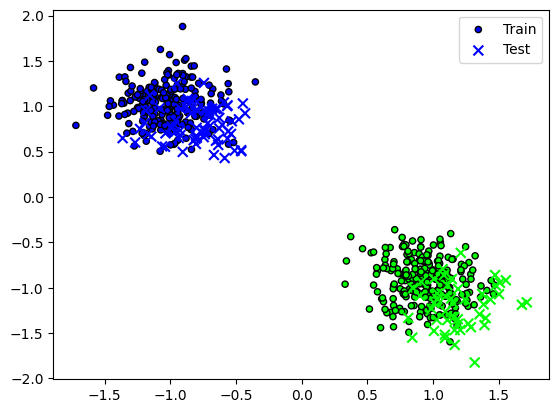

In [33]:
n_features = 2
n_classes = 2
n_samples= 600
cluster_std = 0.8


X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, cluster_std=cluster_std, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = standard_scaler(X_train)
X_test = standard_scaler(X_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.brg, edgecolor='k', s=20, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.brg, marker='x', s=50, label='Test')

plt.legend()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

In [34]:
mlp_2 = NeuralNetwork(loss=NeuralNetwork.loss_mse)

mlp_2.add(LayerDense(2, 1, LayerDense.sigmoid))

Total iterations 480
Iterations of each epoch 48
Validation set size: 48
Training set size: 432
Epoch: 0/10 | loss 0.05006121172307382 | accuracy 1.0 | validation loss 0.052509150388570264 | validation accuracy 1.0
Epoch: 1/10 | loss 0.044338074600497004 | accuracy 1.0 | validation loss 0.046410843131516166 | validation accuracy 1.0
Epoch: 2/10 | loss 0.03969518389079014 | accuracy 1.0 | validation loss 0.04146331488806695 | validation accuracy 1.0
Epoch: 3/10 | loss 0.03586812907011666 | accuracy 1.0 | validation loss 0.03738623275811653 | validation accuracy 1.0
Epoch: 4/10 | loss 0.032669006867021094 | accuracy 1.0 | validation loss 0.03397977993751578 | validation accuracy 1.0
Epoch: 5/10 | loss 0.029961506807161392 | accuracy 1.0 | validation loss 0.03109868459052258 | validation accuracy 1.0
Epoch: 6/10 | loss 0.02764485214879382 | accuracy 1.0 | validation loss 0.028635372546432503 | validation accuracy 1.0
Epoch: 7/10 | loss 0.02564323340779567 | accuracy 1.0 | validation loss 

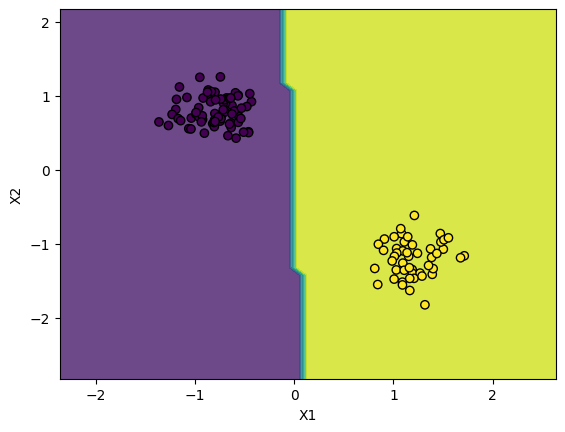

In [35]:
reshaped_y_true = y_train.reshape(-1, 1)  # [1, 0, 0, 0] -> [[1], [0], [0], [0]] | since here we have outputs from 

mlp_2.fit(X_train, reshaped_y_true, 0.03, 10, 10)

plot_decision_boundary(mlp_2, X_test, y_test.reshape(-1, 1))

<h2> Output Softmax (n classes) </h2>

X_train shape: (240, 2)
y_train shape: (240, 5)
X_test shape: (60, 2)
y_test shape: (60, 5)


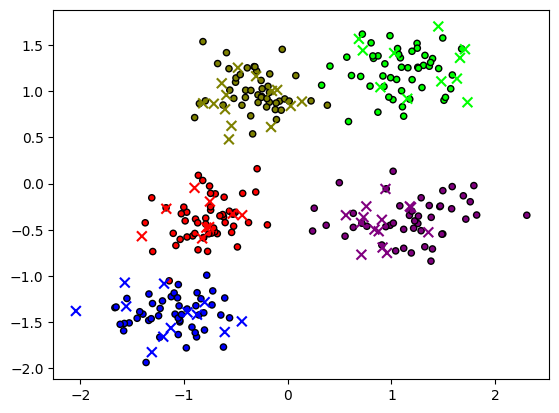

In [305]:
n_dimensions = 2
n_classes = 5
n_samples= 300
cluster_std = 1.1

X, y = make_blobs(n_samples=n_samples, n_features=n_dimensions, centers=n_classes, cluster_std=cluster_std, random_state=40)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = standard_scaler(X_train)
X_test = standard_scaler(X_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.brg, edgecolor='k', s=20, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.brg, marker='x', s=50, label='Test')


encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

In [366]:
def plot_decision_boundary_one_hot(model, X, y, resolution=0.02, val_accuracy=None):
    # Define the color maps
    markers = ('s', 'x', 'o', '^', 'v', '+', 'p', 'd', 'h', '8', '<', '>')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan', 'orange', 'pink', 'purple', 'brown', 'black', 'yellow', 'green')
    cmap = ListedColormap(colors[:len(np.unique(np.argmax(y, axis=1)))])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    grid = np.c_[xx.ravel(), yy.ravel()]
    
    Z = model.forward(grid)
    
    Z = np.argmax(Z, axis=1)
    
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    if val_accuracy:
        plt.title(f'Validation accuracy: {val_accuracy}')

    # Plot the data points
    for idx, cl in enumerate(np.unique(np.argmax(y, axis=1))):
        plt.scatter(x=X[np.argmax(y, axis=1) == cl, 0], 
                    y=X[np.argmax(y, axis=1) == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    plt.legend(loc='upper left')

    plt.show()


In [355]:
mlp_n_class = NeuralNetwork(loss=NeuralNetwork.loss_categorical_crossentropy)

mlp_n_class.add(LayerDense(n_dimensions, 16, LayerDense.relu))
mlp_n_class.add(LayerDense(16, 8, LayerDense.relu))
mlp_n_class.add(LayerDense(8, n_classes, LayerDense.softmax))

Total iterations 24
Iterations of each epoch 24
Validation set size: 24
Training set size: 216
Epoch: 0/1 | loss 0.1653918075397093 | accuracy 0.7824074074074074 | validation loss 0.17559751664629855 | validation accuracy 0.875


C:\Users\ferra\AppData\Local\Temp\ipykernel_31908\386267551.py:41: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[np.argmax(y, axis=1) == cl, 0],


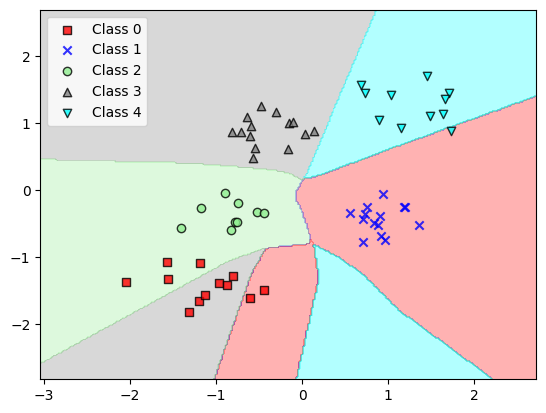

In [365]:
mlp_n_class.fit(X_train, y_train, 0.01, 1, 10)

plot_decision_boundary_one_hot(mlp_n_class, X_test, y_test, 0.02)

In [288]:
mlp_n_class.evaluate(X_test, y_test)

(0.010409029151753875, 0.9833333333333333)

<h1> Testing MNIST </h1>

In [289]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

KeyboardInterrupt: 

In [1841]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

partition = 1
train_images = train_images[:int(len(train_images) * partition)]
train_labels = train_labels[:int(len(train_labels) * partition)]
test_images = test_images[:int(len(test_images) * partition)]
test_labels = test_labels[:int(len(test_labels) * partition)]

# # Preprocess the data
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (60000, 28, 28)
Train labels shape: (60000, 10)
Test images shape: (10000, 28, 28)
Test labels shape: (10000, 10)


In [1864]:
np.random.seed(0)

mlp_mnist = NeuralNetwork(loss=NeuralNetwork.loss_categorical_crossentropy)

mlp_mnist.add(LayerDense(784, 64, LayerDense.relu))
mlp_mnist.add(LayerDense(64, 32, LayerDense.relu))
mlp_mnist.add(LayerDense(32, 10, LayerDense.softmax))

In [1865]:
mlp_mnist.fit(train_images.reshape(-1, 784), train_labels, 0.01, 40, 200)

Total iterations 12000
Iterations of each epoch 300
Validation set size: 6000
Training set size: 54000
Epoch: 0/40 | loss 0.2438718019403402 | accuracy 0.09031481481481482 | validation loss 0.24466356005695925 | validation accuracy 0.08833333333333333
Epoch: 1/40 | loss 0.16178260527135174 | accuracy 0.48138888888888887 | validation loss 0.15790175406949886 | validation accuracy 0.501
Epoch: 2/40 | loss 0.11280190109484438 | accuracy 0.657074074074074 | validation loss 0.10584116513796929 | validation accuracy 0.6948333333333333
Epoch: 3/40 | loss 0.08460856848541719 | accuracy 0.7834629629629629 | validation loss 0.07679179997747275 | validation accuracy 0.8236666666666667
Epoch: 4/40 | loss 0.06607410052331743 | accuracy 0.8449074074074074 | validation loss 0.05823699585747575 | validation accuracy 0.8765
Epoch: 5/40 | loss 0.054548215338278784 | accuracy 0.8625185185185186 | validation loss 0.04677644554483349 | validation accuracy 0.8916666666666667
Epoch: 6/40 | loss 0.04771092904

# Test evaluation loss, accuracy

In [1900]:
mlp_mnist.evaluate(test_images.reshape(-1, 784), test_labels)

(0.019818447101844085, 0.9423)

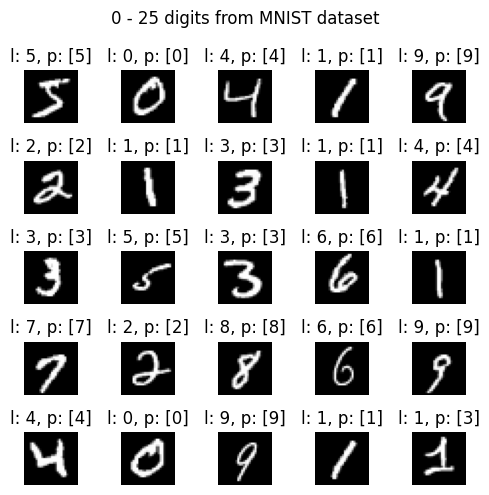

In [1884]:
fig, axes = plt.subplots(5, 5, figsize=(5, 5))

plt.suptitle('0 - 25 digits from MNIST dataset')

for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i], cmap='gray')
    ax.axis('off')

    label = train_labels[i].argmax()
    prediction = mlp_mnist.predict(train_images[i].reshape(-1, 784))

    ax.set_title(f'l: {label}, p: {prediction}')
    # padding
    
plt.tight_layout()

In [ ]:
image = cv2.imread('digit_image.png', cv2.IMREAD_GRAYSCALE)
image = image / 255.0

print(mlp_mnist.predict(image.reshape(1, 784)))

predictions = mlp_mnist.forward(image.reshape(1, 784))

prediction = np.argmax(predictions)
accuracy = np.max(predictions)

print(f'Prediction: {prediction} | Accuracy: {accuracy}')